In [1]:
# Import necessary libraries
from var_cvar_engine import Asset, Portfolio, VaRBacktest
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# Configuration for charts
sns.set_theme()
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [2]:
# Analysis parameters
CONFIDENCE_LEVEL = 95
INVESTMENT_AMOUNT = 1000000  # 1 million monetary units
START_DATE = '2019-01-01'
END_DATE = date.today()

In [3]:
stocks = [
    # Technology
    ["ASML Holding", "ASML.AS"],      # Netherlands
    ["SAP", "SAP.DE"],                # Germany
    
    # Consumer Staples
    ["Danone", "BN.PA"],              # France
    ["Unilever", "ULVR.L"],           # UK
    
    # Defense
    ["Safran", "SAF.PA"],             # France
    ["BAE Systems", "BA.L"],          # UK
    
    # Financial
    ["BNP Paribas", "BNP.PA"],        # France
    ["HSBC Holdings", "HSBA.L"],      # UK
    
    # Energy
    ["TotalEnergies", "TTE.PA"],      # France
    ["Shell", "SHEL.L"]               # Netherlands/UK
]

weights = [0.10] * 10

In [4]:
# Asset object creation
assets = [Asset(stock[0], stock[1],START_DATE,END_DATE) for stock in stocks]

# Portfolio object creation
portfolio = Portfolio(
    "European Equity Portfolio",
    assets=assets,
    weights=weights,
    conf_level=CONFIDENCE_LEVEL,
    initial_value=INVESTMENT_AMOUNT,
    time_horizon=1
)

In [5]:
print(portfolio)


Portfolio Summary: European Equity Portfolio
Initial Value: $1,000,000
Confidence Level: 95.00% | Time Horizon: 1 days
----------------------------------------------------------------------------------------------------
Assets:
  + ASML Holding (ASML.AS) | Weight: 10.00% | Daily μ: 0.117% | Daily σ: 2.300% | Ann. μ: 29.52% | Ann. σ: 36.51%
  + SAP          (SAP.DE) | Weight: 10.00% | Daily μ: 0.074% | Daily σ: 1.720% | Ann. μ: 18.74% | Ann. σ: 27.31%
  + Danone       (BN.PA) | Weight: 10.00% | Daily μ: 0.017% | Daily σ: 1.254% | Ann. μ:  4.37% | Ann. σ: 19.90%
  + Unilever     (ULVR.L) | Weight: 10.00% | Daily μ: 0.013% | Daily σ: 1.260% | Ann. μ:  3.29% | Ann. σ: 20.00%
  + Safran       (SAF.PA) | Weight: 10.00% | Daily μ: 0.088% | Daily σ: 2.315% | Ann. μ: 22.24% | Ann. σ: 36.75%
  + BAE Systems  (BA.L) | Weight: 10.00% | Daily μ: 0.094% | Daily σ: 1.666% | Ann. μ: 23.80% | Ann. σ: 26.45%
  + BNP Paribas  (BNP.PA) | Weight: 10.00% | Daily μ: 0.066% | Daily σ: 2.117% | Ann. μ: 16.72%

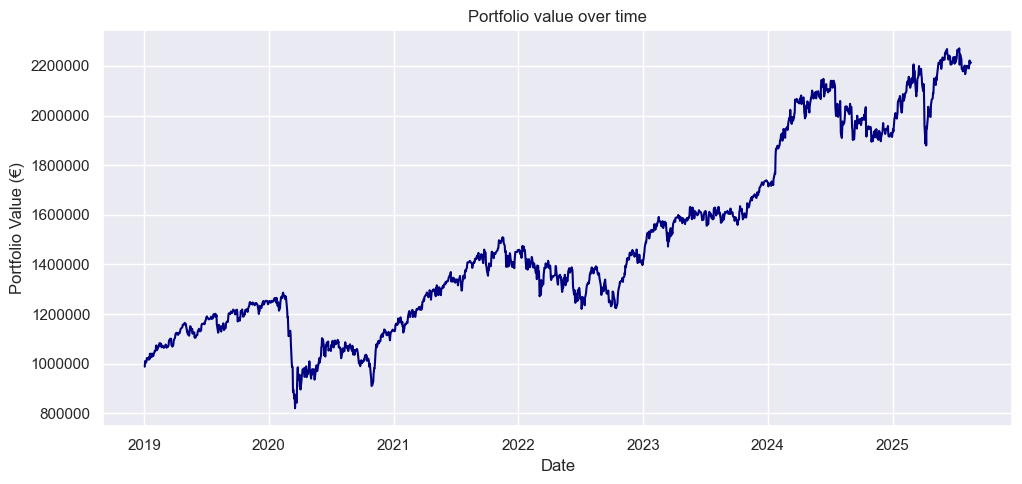

In [6]:
portfolio.plot_portfolio_value()

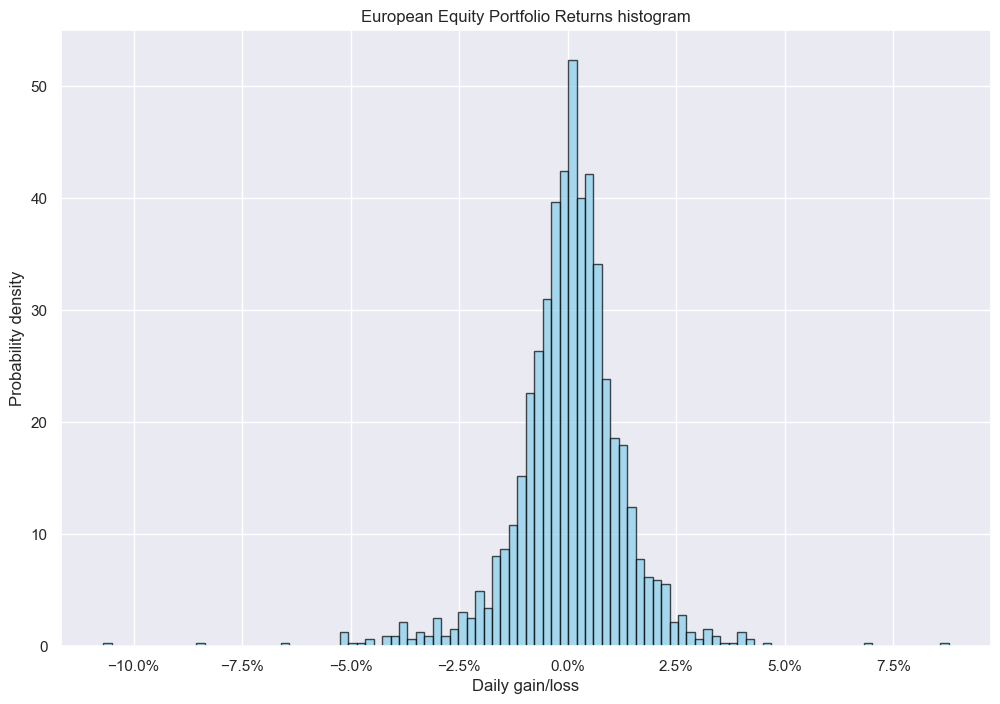

In [7]:
portfolio.plot_returns()

In [8]:
# VaR calculation

historical_var = portfolio.historical_var()
parametric_var, components_var = portfolio.variance_covariance_var()
cornish_fisher_var = portfolio.cornish_fisher_var()

decay_factor = 0.94 # recommended by RiskMetrics
ewma_var = portfolio.ewma_var(decay_factor)

print(F'Daily VaR at {CONFIDENCE_LEVEL}%:\n')
print(f'- Historical VaR: {historical_var:,.4%}')
print(f'- Parametric VaR: {parametric_var:,.4%}')
print('Component VaR by asset:')
for i,asset in enumerate(assets):
    print(f'   - {asset.name}: {components_var[i]:.4%}')
print(f'- Cornish-Fisher VaR: {cornish_fisher_var:,.4%}')
print(f'- EWMA VaR (λ={decay_factor}): {ewma_var:,.4%}')



Daily VaR at 95%:

- Historical VaR: 1.9310%
- Parametric VaR: 1.8897%
Component VaR by asset:
   - ASML Holding: 0.2248%
   - SAP: 0.1773%
   - Danone: 0.0994%
   - Unilever: 0.0710%
   - Safran: 0.2976%
   - BAE Systems: 0.1368%
   - BNP Paribas: 0.2696%
   - HSBC Holdings: 0.1888%
   - TotalEnergies: 0.2340%
   - Shell: 0.2384%
- Cornish-Fisher VaR: 2.0857%
- EWMA VaR (λ=0.94): 1.2077%


In [9]:
methods = ['historical','parametric','cornish-fisher','EWMA']
cvars = []
for method in methods:
    print(f'CVaR using {method} method: {portfolio.compute_cvar(method=method):.4%}')

CVaR using historical method: 3.2163%
CVaR using parametric method: 2.6625%
CVaR using cornish-fisher method: 2.5007%
CVaR using EWMA method: 1.6225%


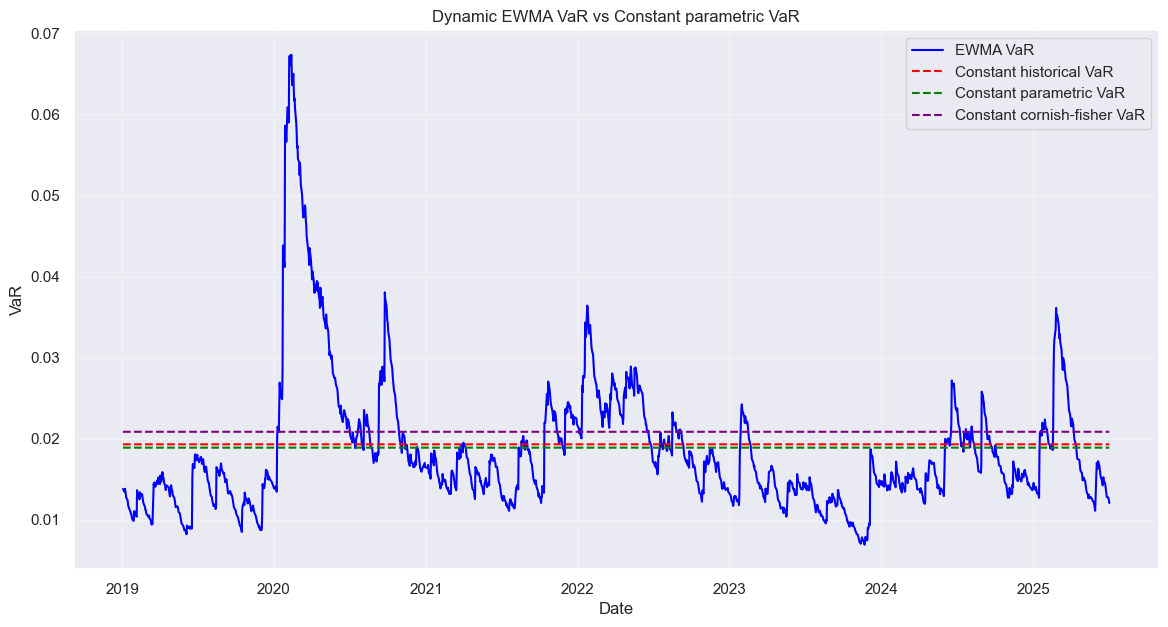

In [10]:
# Comparison of EWMA VaR over time vs constant parametric VaR
var_ewma_series = portfolio.compute_ewma_var_series(decay_factor)
historical_var_constant = [historical_var] * len(var_ewma_series)
parametric_var_constant = [parametric_var] * len(var_ewma_series)
cornish_fisher_var_constant = [cornish_fisher_var] * len(var_ewma_series)

plt.figure(figsize=(14, 7))
plt.plot(portfolio.log_port_returns.index[:len(var_ewma_series)], var_ewma_series, label='EWMA VaR', color='blue')
plt.plot(portfolio.log_port_returns.index[:len(var_ewma_series)], historical_var_constant, label='Constant historical VaR', color='red', linestyle='--')
plt.plot(portfolio.log_port_returns.index[:len(var_ewma_series)], parametric_var_constant, label='Constant parametric VaR', color='green', linestyle='--')
plt.plot(portfolio.log_port_returns.index[:len(var_ewma_series)], cornish_fisher_var_constant, label='Constant cornish-fisher VaR', color='purple', linestyle='--')
plt.title('Dynamic EWMA VaR vs Constant parametric VaR')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

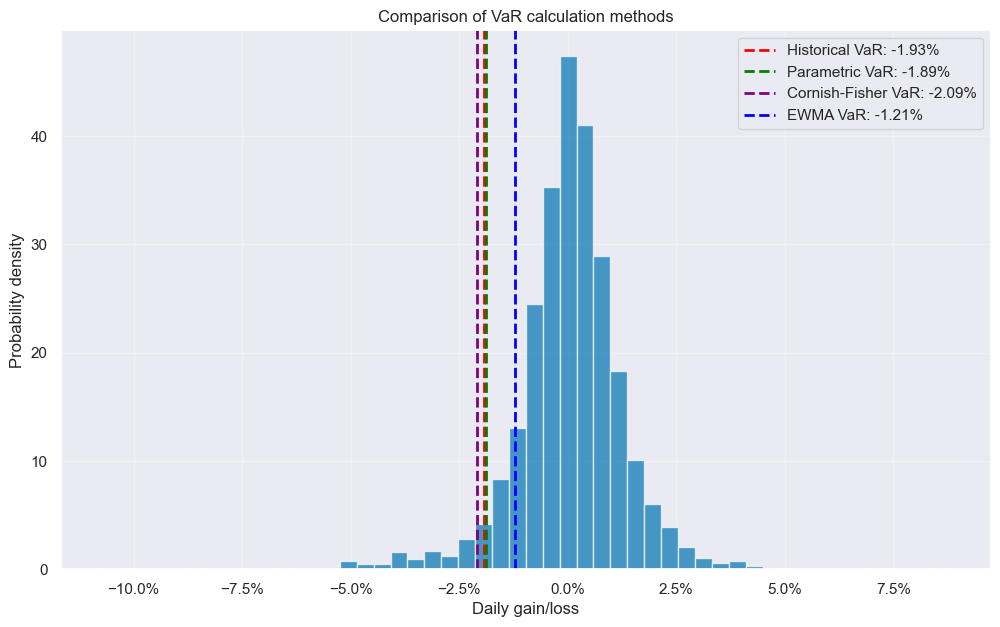

In [11]:
portfolio.plot_vars(decay_factor)

In [12]:
backtest = VaRBacktest(portfolio, window_size=252)
results = backtest.run_all_backtests(ewma_decay=0.94)

Running backtests with 252-day rolling window
Total test observations: 1405
Expected violation rate: 5.00%
--------------------------------------------------
Historical VaR:      5.20% violation rate
Parametric VaR:      5.48% violation rate
Cornish-Fisher VaR:  5.12% violation rate
EWMA VaR (λ=0.94):   5.69% violation rate
